#### Importing libraries

In [2]:
import torch, gc
import os
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from torchvision.datasets.utils import download_url
import matplotlib.pyplot as plt
%matplotlib inline

#### Normalizing stats

In [3]:
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

#### Transormations added to normalize and flip images

In [4]:
train_tfms = tt.Compose([tt.Resize(64),
                        tt.RandomHorizontalFlip(),
                        tt.RandomVerticalFlip(),
                        tt.RandomAutocontrast(p=0.5),
                        tt.RandomInvert(),
                        
                        
                        tt.ToTensor(),
                        tt.Normalize(*stats,inplace=True)
                        ])
test_tfms = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

#### Creating training dataset and test dataset

In [5]:
train_ds = ImageFolder('data/train',train_tfms)


In [7]:
from torch.utils.data import random_split

test_size = 1000
train_size = len(train_ds)-test_size
train_ds,test_ds = random_split(train_ds, [train_size,test_size])
len(train_ds),len(test_ds)

(5897, 1000)

#### Classes
##### 1)Youngster
##### 2)Senoir Citizens
##### 3) Adult

In [8]:
classes = os.listdir("data/train")
classes

['youngster', 'senior citizen', 'adult']

In [9]:
batch_size = 16

#### Specifying dataloaders

In [10]:
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)
test_dl = DataLoader(test_ds,batch_size*2,num_workers=3,pin_memory=True)

##### Functions for denormalization and checking data

In [11]:
def denormalize(images,means,stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

def show_batch(dl):
    for images,labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]);ax.set_yticks([])
        denorm_images =  denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1,2,0).clamp(0,1))
        break

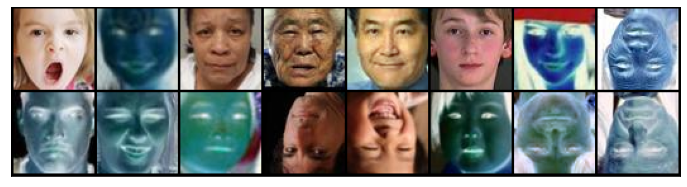

In [12]:
show_batch(train_dl)

#### Using GPU for computation

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

#### Loading dataloader to GPU

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

#### Functions for evaluation of diffrent parameters like accuracy and loss.

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        # saving model above 85% accuracy
        if epoch_acc.item() > 0.70:
            torch.save(model.state_dict(), 'weights/face_detect_{}.pth'.format(epoch_acc.item()))
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## Model RESNET

In [17]:
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.norm15 = nn.BatchNorm2d(15)
        self.norm30 = nn.BatchNorm2d(30)
        self.norm60 = nn.BatchNorm2d(60)
        self.norm120 = nn.BatchNorm2d(120)
        self.norm200 = nn.BatchNorm2d(200)
        self.norm300 = nn.BatchNorm2d(300)
        self.norm360 = nn.BatchNorm2d(360)
        self.norm512 = nn.BatchNorm2d(512)
        #--------------------
        self.conv15 = nn.Conv2d(3,15,kernel_size=3,stride=1,padding=1)#15x64x64
        self.conv30 = nn.Conv2d(15,30,kernel_size=3,stride=1,padding=1)#30x64x64
        self.conv60 = nn.Conv2d(30,60,kernel_size=3,stride=2,padding=1)#60x32x32

        self.res60 = nn.Conv2d(60,60,kernel_size=3,stride=1,padding=1)
        #---------------
        self.conv120a = nn.Conv2d(60,60,kernel_size=3,stride=1,padding=1)
        #------------
        self.conv200 = nn.Conv2d(60,200,kernel_size=3,stride=1,padding=1)#200x32x32
        self.conv200a = nn.Conv2d(200,200,kernel_size=3,stride=2,padding=1)#200x16x16
        

        self.res200 = nn.Conv2d(200,200,kernel_size=3,stride=1,padding=1)
        #------------------
        self.conv300 = nn.Conv2d(200,200,kernel_size=3,stride=1,padding=1)
        self.conv360 = nn.Conv2d(200,360,kernel_size=3,stride=1,padding=1)#360x16x16
        self.conv512 = nn.Conv2d(360,512,kernel_size=3,stride=1,padding=1)#512x16x16

        

        #===========================#
        self.pool = nn.MaxPool2d(2,2)
        self.avgpool = nn.AvgPool2d(2,2)
        self.flat = nn.Flatten()

        self.linear = nn.Linear(512*2*2,3)

    def forward(self,xb):
      out = torch.relu(self.norm15(self.conv15(xb)))#15x64x64

      out = torch.relu(self.norm30(self.conv30(out)))#30x64x64

      out = torch.relu(self.norm60(self.conv60(out)))#60x32x32

      x = self.res60(out)#120x32x32

      out = torch.relu(self.conv120a(out)+x)

      out = torch.relu(self.norm200(self.conv200(out)))

      out = torch.relu(self.conv200a(out))

      

      x = self.res200(out)

      out = torch.relu(self.conv300(out)+x)

      out = torch.relu(self.norm360(self.conv360(out)))

      out = torch.relu(self.norm512(self.conv512(out)))

      out = self.avgpool(out)#512x8x8
      out = self.avgpool(out)#512 4 4
      out = self.avgpool(out)#512 2 2
    #   print("Before Flat",out.shape)
      out = self.flat(out)
    #   print("after flat",out.shape)
      out = self.linear(out)
    #   print("After Linear",out.shape)
      return out




#### Clearing GPU cache

In [18]:
gc.collect()
torch.cuda.empty_cache()

#### Uploading model to GPU

In [19]:
model = to_device(ResNet9(3,2),device)
model

ResNet9(
  (norm15): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm30): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm60): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm120): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm200): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm300): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm360): BatchNorm2d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm512): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv15): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv30): Conv2d(15, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv60): Conv2d(30, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (res60): C

### Training Function

In [20]:

for images,labels in train_dl:
    print(images.shape)
    out = model(images)
    print(out.shape)
    break

torch.Size([16, 3, 64, 64])
torch.Size([16, 3])


In [21]:
from tqdm import tqdm

In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Training parameters

In [26]:
epochs = 50
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

### Training phase

In [28]:
ret_data = fit_one_cycle(epochs,max_lr,model,train_dl,test_dl,weight_decay,grad_clip,opt_func)

100%|██████████| 369/369 [00:18<00:00, 20.15it/s]


Epoch [0], last_lr: 0.00001, train_loss: 0.0782, val_loss: 0.4027, val_acc: 0.8496


100%|██████████| 369/369 [00:18<00:00, 20.02it/s]


Epoch [1], last_lr: 0.00001, train_loss: 0.0745, val_loss: 0.4035, val_acc: 0.8438


100%|██████████| 369/369 [00:18<00:00, 20.04it/s]


Epoch [2], last_lr: 0.00001, train_loss: 0.0734, val_loss: 0.4086, val_acc: 0.8496


100%|██████████| 369/369 [00:18<00:00, 19.88it/s]


Epoch [3], last_lr: 0.00002, train_loss: 0.0801, val_loss: 0.4351, val_acc: 0.8584


100%|██████████| 369/369 [00:18<00:00, 19.65it/s]


Epoch [4], last_lr: 0.00003, train_loss: 0.0786, val_loss: 0.4640, val_acc: 0.8418


100%|██████████| 369/369 [00:18<00:00, 19.70it/s]


Epoch [5], last_lr: 0.00004, train_loss: 0.0818, val_loss: 0.4448, val_acc: 0.8496


100%|██████████| 369/369 [00:18<00:00, 19.69it/s]


Epoch [6], last_lr: 0.00005, train_loss: 0.1016, val_loss: 0.5485, val_acc: 0.8193


100%|██████████| 369/369 [00:18<00:00, 19.68it/s]


Epoch [7], last_lr: 0.00006, train_loss: 0.1245, val_loss: 0.5017, val_acc: 0.8447


100%|██████████| 369/369 [00:18<00:00, 19.63it/s]


Epoch [8], last_lr: 0.00007, train_loss: 0.1478, val_loss: 0.6532, val_acc: 0.7744


100%|██████████| 369/369 [00:18<00:00, 19.71it/s]


Epoch [9], last_lr: 0.00008, train_loss: 0.1545, val_loss: 0.6344, val_acc: 0.7930


100%|██████████| 369/369 [00:18<00:00, 19.87it/s]


Epoch [10], last_lr: 0.00008, train_loss: 0.1743, val_loss: 0.5359, val_acc: 0.8086


100%|██████████| 369/369 [00:18<00:00, 19.83it/s]


Epoch [11], last_lr: 0.00009, train_loss: 0.1815, val_loss: 0.5148, val_acc: 0.8164


100%|██████████| 369/369 [00:18<00:00, 19.87it/s]


Epoch [12], last_lr: 0.00010, train_loss: 0.1906, val_loss: 0.6037, val_acc: 0.7812


100%|██████████| 369/369 [00:18<00:00, 19.66it/s]


Epoch [13], last_lr: 0.00010, train_loss: 0.2071, val_loss: 0.5091, val_acc: 0.8203


100%|██████████| 369/369 [00:18<00:00, 19.86it/s]


Epoch [14], last_lr: 0.00010, train_loss: 0.1983, val_loss: 0.5284, val_acc: 0.8047


100%|██████████| 369/369 [00:18<00:00, 19.80it/s]


Epoch [15], last_lr: 0.00010, train_loss: 0.1847, val_loss: 0.5241, val_acc: 0.8057


100%|██████████| 369/369 [00:18<00:00, 19.89it/s]


Epoch [16], last_lr: 0.00010, train_loss: 0.1758, val_loss: 0.4936, val_acc: 0.8281


100%|██████████| 369/369 [00:18<00:00, 19.86it/s]


Epoch [17], last_lr: 0.00010, train_loss: 0.1842, val_loss: 0.4561, val_acc: 0.8379


100%|██████████| 369/369 [00:18<00:00, 19.87it/s]


Epoch [18], last_lr: 0.00010, train_loss: 0.1776, val_loss: 0.5365, val_acc: 0.8125


100%|██████████| 369/369 [00:18<00:00, 19.85it/s]


Epoch [19], last_lr: 0.00010, train_loss: 0.1643, val_loss: 0.5214, val_acc: 0.8174


100%|██████████| 369/369 [00:18<00:00, 19.87it/s]


Epoch [20], last_lr: 0.00009, train_loss: 0.1660, val_loss: 0.5553, val_acc: 0.8105


100%|██████████| 369/369 [00:18<00:00, 19.89it/s]


Epoch [21], last_lr: 0.00009, train_loss: 0.1417, val_loss: 0.5073, val_acc: 0.8096


100%|██████████| 369/369 [00:18<00:00, 19.85it/s]


Epoch [22], last_lr: 0.00009, train_loss: 0.1556, val_loss: 0.4983, val_acc: 0.8340


100%|██████████| 369/369 [00:18<00:00, 19.85it/s]


Epoch [23], last_lr: 0.00008, train_loss: 0.1304, val_loss: 0.5054, val_acc: 0.8271


100%|██████████| 369/369 [00:18<00:00, 19.89it/s]


Epoch [24], last_lr: 0.00008, train_loss: 0.1315, val_loss: 0.4739, val_acc: 0.8418


100%|██████████| 369/369 [00:18<00:00, 19.84it/s]


Epoch [25], last_lr: 0.00008, train_loss: 0.1325, val_loss: 0.4478, val_acc: 0.8428


100%|██████████| 369/369 [00:18<00:00, 19.89it/s]


Epoch [26], last_lr: 0.00007, train_loss: 0.1119, val_loss: 0.4888, val_acc: 0.8408


100%|██████████| 369/369 [00:18<00:00, 19.86it/s]


Epoch [27], last_lr: 0.00007, train_loss: 0.0971, val_loss: 0.5685, val_acc: 0.8184


100%|██████████| 369/369 [00:18<00:00, 19.92it/s]


Epoch [28], last_lr: 0.00007, train_loss: 0.1031, val_loss: 0.5750, val_acc: 0.8184


100%|██████████| 369/369 [00:18<00:00, 19.82it/s]


Epoch [29], last_lr: 0.00006, train_loss: 0.0865, val_loss: 0.5179, val_acc: 0.8330


100%|██████████| 369/369 [00:18<00:00, 19.90it/s]


Epoch [30], last_lr: 0.00006, train_loss: 0.0776, val_loss: 0.4342, val_acc: 0.8506


100%|██████████| 369/369 [00:18<00:00, 19.81it/s]


Epoch [31], last_lr: 0.00005, train_loss: 0.0723, val_loss: 0.4825, val_acc: 0.8525


100%|██████████| 369/369 [00:18<00:00, 19.84it/s]


Epoch [32], last_lr: 0.00005, train_loss: 0.0693, val_loss: 0.5196, val_acc: 0.8359


100%|██████████| 369/369 [00:18<00:00, 19.90it/s]


Epoch [33], last_lr: 0.00004, train_loss: 0.0616, val_loss: 0.4694, val_acc: 0.8486


100%|██████████| 369/369 [00:18<00:00, 19.70it/s]


Epoch [34], last_lr: 0.00004, train_loss: 0.0543, val_loss: 0.5291, val_acc: 0.8467


100%|██████████| 369/369 [00:18<00:00, 19.77it/s]


Epoch [35], last_lr: 0.00003, train_loss: 0.0446, val_loss: 0.4823, val_acc: 0.8623


100%|██████████| 369/369 [00:18<00:00, 19.86it/s]


Epoch [36], last_lr: 0.00003, train_loss: 0.0413, val_loss: 0.5181, val_acc: 0.8545


100%|██████████| 369/369 [00:18<00:00, 19.89it/s]


Epoch [37], last_lr: 0.00003, train_loss: 0.0380, val_loss: 0.4710, val_acc: 0.8486


100%|██████████| 369/369 [00:18<00:00, 19.89it/s]


Epoch [38], last_lr: 0.00002, train_loss: 0.0357, val_loss: 0.4997, val_acc: 0.8486


100%|██████████| 369/369 [00:18<00:00, 19.85it/s]


Epoch [39], last_lr: 0.00002, train_loss: 0.0285, val_loss: 0.5308, val_acc: 0.8525


100%|██████████| 369/369 [00:18<00:00, 19.82it/s]


Epoch [40], last_lr: 0.00002, train_loss: 0.0269, val_loss: 0.4607, val_acc: 0.8574


100%|██████████| 369/369 [00:18<00:00, 19.92it/s]


Epoch [41], last_lr: 0.00001, train_loss: 0.0240, val_loss: 0.5450, val_acc: 0.8457


100%|██████████| 369/369 [00:18<00:00, 19.73it/s]


Epoch [42], last_lr: 0.00001, train_loss: 0.0167, val_loss: 0.4374, val_acc: 0.8691


100%|██████████| 369/369 [00:18<00:00, 19.79it/s]


Epoch [43], last_lr: 0.00001, train_loss: 0.0142, val_loss: 0.5250, val_acc: 0.8516


100%|██████████| 369/369 [00:18<00:00, 19.85it/s]


Epoch [44], last_lr: 0.00000, train_loss: 0.0159, val_loss: 0.4858, val_acc: 0.8584


100%|██████████| 369/369 [00:18<00:00, 19.88it/s]


Epoch [45], last_lr: 0.00000, train_loss: 0.0166, val_loss: 0.5194, val_acc: 0.8555


100%|██████████| 369/369 [00:18<00:00, 19.83it/s]


Epoch [46], last_lr: 0.00000, train_loss: 0.0168, val_loss: 0.5395, val_acc: 0.8516


100%|██████████| 369/369 [00:18<00:00, 19.83it/s]


Epoch [47], last_lr: 0.00000, train_loss: 0.0162, val_loss: 0.4643, val_acc: 0.8643


100%|██████████| 369/369 [00:18<00:00, 19.80it/s]


Epoch [48], last_lr: 0.00000, train_loss: 0.0129, val_loss: 0.4798, val_acc: 0.8672


100%|██████████| 369/369 [00:18<00:00, 19.86it/s]


Epoch [49], last_lr: 0.00000, train_loss: 0.0130, val_loss: 0.5024, val_acc: 0.8564


In [ ]:
torch.save(model.state_dict(),"age_65.pth")

# Evaluate your own validation dataset.

In [ ]:
# def validate_results(path_to_validation_data):
#     val_ds = ImageFolder(path_to_validation_data,test_tfms)
#     val_dl = DataLoader(val_ds,batch_size=32,shuffle=True,num_workers=3,pin_memory=True)
#     model = ResNet9(3,10)
#     model.load_state_dict(torch.load("imp/face_detect_0.9877451062202454.pth"))
#     results = evaluate(model,val_dl)
#     return results

# print(validate_results("data/test"))

### Functions for plotting graphs

In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Acc vs Epochs')

def plot_loss(history):
  loss = [x['val_loss'] for x in history]
  plt.plot(loss, '-x')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Loss vs Epochs')

def plot_lr(history):
  lr = [x['lrs'] for x in history]
  plt.plot(lr, '-x')
  plt.xlabel('epoch')
  plt.ylabel('learning_rates')
  plt.title('Learning_rates vs Epochs')

In [ ]:
plot_loss(ret_data)

In [ ]:
plot_accuracies(ret_data)

In [ ]:
plot_lr(ret_data)

### Function for predicting Image

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    a, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
img, label = test_ds[100]
print(img.shape)
plt.imshow(img.permute(1, 2, 0))
print('Label:', classes[label], ', Predicted:', predict_image(img, model))